# Models


### Import libraries

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../data')
from process_data import process_data
from vgg16 import vgg16_labels
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


In [118]:
import nltk
from nltk.corpus import wordnet

def categorize_words(words):
    categories = ['person', 'vehicle', 'object', 'animal', 'sport', 'food', 'furniture', 'electronic', 'appliance', 'other']
    word_categories = {}
    for word in words:
        synsets = wordnet.synsets(word)
        if len(synsets) == 0:
            word_categories[word] = 'other'
        else:
            # Get the first synset
            synset = synsets[0]
            # Traverse the hypernym hierarchy to find a category
            hypernyms = synset.hypernyms()
            category_found = False
            while hypernyms and not category_found:
                hypernym = hypernyms[0]
                hypernym_name = hypernym.name()
                for category in categories:
                    if category in hypernym_name:
                        word_categories[word] = category
                        category_found = True
                        break
                hypernyms = hypernym.hypernyms()
            if not category_found:
                word_categories[word] = 'other'
    return word_categories

In [119]:
#pull in thumbnail image classifications
#!!!!WARNING - CPU INTENSIVE
vgg16_label_df = pd.read_csv('../data/vgg16.csv',index_col=0)

In [120]:
words = vgg16_label_df['label_1'].astype(str).unique()
word_categories = categorize_words(words)

# create a dictionary that maps words to categories
word_to_category = {word: category for word, category in word_categories.items()}

# add a new column to Xception_label_df that maps label_1 values to categories
vgg16_label_df['label_1_category'] = vgg16_label_df['label_1'].astype(str).map(word_to_category)

In [121]:
words = vgg16_label_df['label_2'].astype(str).unique()
word_categories = categorize_words(words)

# create a dictionary that maps words to categories
word_to_category = {word: category for word, category in word_categories.items()}

# add a new column to Xception_label_df that maps label_1 values to categories
vgg16_label_df['label_2_category'] = vgg16_label_df['label_2'].astype(str).map(word_to_category)

In [122]:
words = vgg16_label_df['label_3'].astype(str).unique()
word_categories = categorize_words(words)

# create a dictionary that maps words to categories
word_to_category = {word: category for word, category in word_categories.items()}

# add a new column to Xception_label_df that maps label_1 values to categories
vgg16_label_df['label_3_category'] = vgg16_label_df['label_3'].astype(str).map(word_to_category)

In [123]:
#pull in train and test datasets
X_train, y_train,X_test,y_test = process_data(buckets = 10)

#merge labels into test and train data set
X_train = X_train.merge(vgg16_label_df, on='video_id')
X_test = X_test.merge(vgg16_label_df, on='video_id')

# Combine X_train and X_test into one DataFrame
combined_df = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

#remove this line to include video stats
#combined_df = combined_df[['label_1_category']]

# One-hot encode the label columns
label_dummies = pd.get_dummies(combined_df[['label_1_category',]], prefix='', prefix_sep='')

X_train = pd.concat([combined_df.drop(['label_1_category'], axis=1)[:len(X_train)], label_dummies[:len(X_train)]], axis=1)
X_test = pd.concat([combined_df.drop(['label_1_category'], axis=1)[len(X_train):], label_dummies[len(X_train):]], axis=1)



### Baseline Model

Find the most common bucket and make that the (constant) prediction.


In [124]:
most_common_bucket = y_train.iloc[:,0].value_counts().sort_values(ascending =False).index[0]

In [125]:
most_common_bucket_array = np.full(len(y_test),most_common_bucket)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
          10       0.00      0.00      0.00        44
          20       0.00      0.00      0.00        58
          30       0.07      1.00      0.13        32
          40       0.00      0.00      0.00        54
          50       0.00      0.00      0.00        35
          60       0.00      0.00      0.00        40
          70       0.00      0.00      0.00        57
          80       0.00      0.00      0.00        44
          90       0.00      0.00      0.00        50

    accuracy                           0.07       465
   macro avg       0.01      0.10      0.01       465
weighted avg       0.00      0.07      0.01       465

Confusion Matrix:



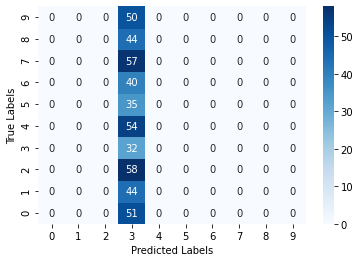

In [126]:
cm = confusion_matrix(y_test, most_common_bucket_array)
cr = classification_report(y_test, most_common_bucket_array)

print("Classification Report:\n", cr)

print("Confusion Matrix:\n")
# Plot confusion matrix with axis labels
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
ax.invert_yaxis()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Model: Logistic Regression

In [127]:
X_train = X_train.drop(columns=X_train.select_dtypes(include=['object','datetime64[ns, UTC]']).columns)
X_test = X_test.drop(columns=X_test.select_dtypes(include=['object','datetime64[ns, UTC]']).columns)

In [128]:
y_train['views_category_10']

2316    60
406     30
645     70
1206    90
592     70
        ..
1095    10
1462    30
2197    30
1039     0
1147    30
Name: views_category_10, Length: 1859, dtype: category
Categories (10, int64): [0 < 10 < 20 < 30 ... 60 < 70 < 80 < 90]

In [ ]:
# Instantiate the model with default hyperparameters
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the model on the training data
logreg.fit(X_train, y_train['views_category_10'])

# Make predictions on the test data
y_pred = logreg.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Classification Report:\n", cr)

print("Confusion Matrix:\n")
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
ax.invert_yaxis()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.02      0.04        51
          10       0.00      0.00      0.00        44
          20       0.12      0.02      0.03        58
          30       0.07      0.19      0.11        32
          40       0.00      0.00      0.00        54
          50       0.05      0.14      0.08        35
          60       0.14      0.17      0.16        40
          70       0.06      0.04      0.04        57
          80       0.22      0.05      0.08        44
          90       0.14      0.50      0.21        50

    accuracy                           0.11       465
   macro avg       0.13      0.11      0.07       465
weighted avg       0.13      0.11      0.07       465

Confusion Matrix:



### Model: Gradient Boosted Decision Trees


In [ ]:
X_train.columns

In [ ]:
# Instantiate the model with default hyperparameters
gbc = GradientBoostingClassifier()

# Train the model on the training data
gbc.fit(X_train, y_train['views_category_10'])

# Make predictions on the test data
y_pred = gbc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Classification Report:\n", cr)

print("Confusion Matrix:\n")
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
ax.invert_yaxis()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model: Random Forest
This model was optimized using TPOT, an AutoML library.

In [ ]:

# Instantiate the model with default hyperparameters
rfc = RandomForestClassifier()

# Train the model on the training data
rfc.fit(X_train, y_train['views_category_10'])

# Make predictions on the test data
y_pred = rfc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Classification Report:\n", cr)

print("Confusion Matrix:\n")
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
ax.invert_yaxis()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()